# Set Up

In [ ]:
# Install required Python libraries
!pip install openpyxl
!pip install pandarallel
!pip install cycler
!pip install tqdm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.0 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=e32fdb092cc22e19b9ca9167c02bf326f1111ee19bb4c524423e109848edc19e
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


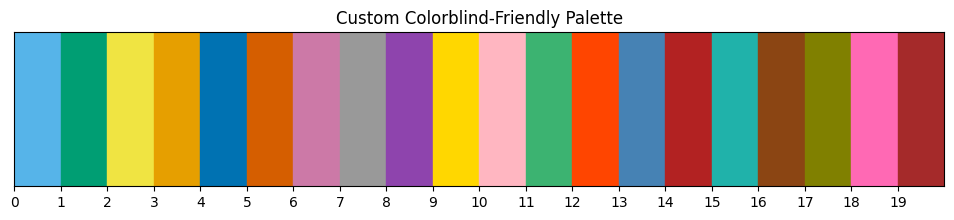

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import scipy  # Correct spelling for import
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from cycler import cycler
from glob import glob
from datetime import datetime
from tqdm import tqdm # For progress bar in Jupyter/Colab environments
import fnmatch
import warnings
import gzip


# Parallel processing
from multiprocessing import Pool, cpu_count
from pandarallel import pandarallel
import time
import re
from collections import Counter

# Initialize pandarallel for parallel processing
pandarallel.initialize(nb_workers=8, progress_bar=True, use_memory_fs=False)

# Set default figure size for plots (optional)
plt.rcParams['figure.figsize'] = (10, 6)

# Set the default color cycle for matplotlib with a colorblind-friendly palette
color_palette = [
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#E69F00",  # orange
    "#0072B2",  # blue
    "#D55E00",  # red-orange
    "#CC79A7",  # pink
    "#999999",  # grey
    "#8E44AD",  # purple
    "#FFD700",  # gold
    "#FFB6C1",  # light pink
    "#3CB371",  # medium sea green
    "#FF4500",  # orange-red
    "#4682B4",  # steel blue
    "#B22222",  # firebrick
    "#20B2AA",  # light sea green
    "#8B4513",  # saddle brown
    "#808000",  # olive
    "#FF69B4",  # hot pink
    "#A52A2A",  # brown
]

plt.rcParams['axes.prop_cycle'] = cycler(color=color_palette)


# Plot a test to visualize the colors
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(color_palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, len(color_palette))
ax.set_yticks([])
ax.set_xticks(range(len(color_palette)))
plt.title("Custom Colorblind-Friendly Palette")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Comments

In [ ]:
# Read the CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/Comments.csv'
comment = pd.read_csv(file_path)
comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634720 entries, 0 to 634719
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   stream_name   634720 non-null  object
 1   post_id       634720 non-null  object
 2   post_title    562660 non-null  object
 3   created_date  634720 non-null  object
 4   comment_id    634720 non-null  object
 5   userid        634630 non-null  object
 6   username      634630 non-null  object
 7   comment_text  634720 non-null  object
 8   like_count    634720 non-null  int64 
 9   report_count  634720 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 48.4+ MB


In [ ]:
# Summary statistics for numerical features
print(comment.describe())

          like_count   report_count
count  634720.000000  634720.000000
mean        0.773191       0.000444
std         1.355870       0.022238
min         0.000000       0.000000
25%         0.000000       0.000000
50%         1.000000       0.000000
75%         1.000000       0.000000
max       148.000000       4.000000


In [ ]:
# Summary statistics for categorical features
print(comment.describe(include='object'))

           stream_name    post_id  post_title             created_date  \
count           634720     634720      562660                   634720   
unique             475     168063      105364                   408186   
top     Employee Voice  7,583,707  Good Sales  July 30, 2023, 10:16 AM   
freq             64331        258        3122                       31   

       comment_id                                userid   username  \
count      634720                                634630     634630   
unique     634720                                 18868      18868   
top     3,695,778  e27234ab-ab36-4b15-817b-fb05fc922d81  us_102769   
freq            1                                 39846      39846   

       comment_text  
count        634720  
unique       406451  
top       Thank you  
freq           6486  


In [ ]:
# Lowercasing all values in the categorical columns (columns with dtype 'object')
categorical_columns = comment.select_dtypes(include='object').columns

# Apply lowercasing to all categorical columns
for column in categorical_columns:
    comment[column] = comment[column].str.lower()


In [ ]:
# Display the first few rows of the DataFrame
comment.iloc[0:5]

,stream_name,post_id,post_title,created_date,comment_id,userid,username,comment_text,like_count,report_count
0,heathrow t5 talk,"5,740,582",happy new year from b shift 🥳🥰,"january 1, 2022, 12:00 am","3,695,778",687b2223-3510-455b-a945-3890d5902069,100002138,happy new year 🥳🥳🥳,2,0
1,center parcs,"5,739,834",2021 service star of the year- monica apellaniz,"january 1, 2022, 12:01 am","3,695,782",09346fb4-d5a3-4aff-a9e1-3678cde7e890,100018046,well done monica xxx,0,0
2,birmingham talk,"5,739,150",happy new year...,"january 1, 2022, 12:01 am","3,695,783",d232d9d3-8f40-4cb9-84f0-5fdb0f3ec241,gb_1011238,happy nee year!! x,0,0
3,birmingham talk,"5,739,150",happy new year...,"january 1, 2022, 12:02 am","3,695,786",d232d9d3-8f40-4cb9-84f0-5fdb0f3ec241,gb_1011238,happy new year! x,0,0
4,birmingham talk,"5,739,150",happy new year...,"january 1, 2022, 12:02 am","3,695,787",2e290e69-ff58-433b-b021-d4e61d81efec,gb_1018928,happy new year! x,0,0


In [ ]:
# Check for missing values by percentage
missing_values = comment.isnull().sum()
missing_percentage = (missing_values / len(comment)) * 100
missing_comment = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_comment)

              Missing Values  Percentage
stream_name                0    0.000000
post_id                    0    0.000000
post_title             72060   11.353038
created_date               0    0.000000
comment_id                 0    0.000000
userid                    90    0.014179
username                  90    0.014179
comment_text               0    0.000000
like_count                 0    0.000000
report_count               0    0.000000


In [ ]:
# Rename the columns
comment = comment.rename(columns={'like_count': 'comment_like_count', 'created_date': 'comment_created_date'})

In [ ]:
# Check for duplicate rows in the 'comments' DataFrame
duplicate_rows_comments = comment[comment.duplicated()]

# Check for duplicate columns in the 'comments' DataFrame
duplicate_columns_comments = []

for i in range(comment.shape[1]):
    for j in range(i + 1, comment.shape[1]):
        if comment.iloc[:, i].equals(comment.iloc[:, j]):
            duplicate_columns_comments.append((comment.columns[i], comment.columns[j]))

# Print results for duplicate rows
if not duplicate_rows_comments.empty:
    print("Duplicate rows found in 'comment':")
    print(duplicate_rows_comments)
else:
    print("No duplicate rows found in 'comment'.")

# Print results for duplicate columns
if duplicate_columns_comments:
    print("\nColumns with duplicate content in 'comment':")
    for col_pair in duplicate_columns_comments:
        print(f"Column '{col_pair[0]}' is identical to column '{col_pair[1]}'")
else:
    print("\nNo columns with duplicate content found in 'comment'.")


No duplicate rows found in 'comment'.

No columns with duplicate content found in 'comment'.


In [ ]:
# Drop the 'report_count' column
comment = comment.drop('report_count', axis=1)

In [ ]:
# Using the assign() method to fill missing values in the columns 'post_title', 'userid', and 'username'
comment = comment.assign(
    post_title=comment['post_title'].fillna('untitled'),
    userid=comment['userid'].fillna('no_userid'),
    username=comment['username'].fillna('no_username')
)

In [ ]:
# Convert the 'created_date' column to datetime format
comment['comment_created_date'] = pd.to_datetime(comment['comment_created_date'], format='%B %d, %Y, %I:%M %p')

# Check the data type to confirm the change
print(comment.dtypes['comment_created_date'])


datetime64[ns]


In [ ]:
# Overview
comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634720 entries, 0 to 634719
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   stream_name           634720 non-null  object        
 1   post_id               634720 non-null  object        
 2   post_title            634720 non-null  object        
 3   comment_created_date  634720 non-null  datetime64[ns]
 4   comment_id            634720 non-null  object        
 5   userid                634720 non-null  object        
 6   username              634720 non-null  object        
 7   comment_text          634720 non-null  object        
 8   comment_like_count    634720 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 43.6+ MB


In [ ]:
# Save the cleaned DataFrame to a CSV file in the specified path
comment.to_csv('/content/drive/MyDrive/Colab Notebooks/TT/DATA/comment_cleaned.csv', index=False)


# Posts

In [ ]:
# Read the CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/Posts.csv'
post = pd.read_csv(file_path)
post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247305 entries, 0 to 247304
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   stream_name     247305 non-null  object
 1   stream_id       247305 non-null  object
 2   post_id         247305 non-null  object
 3   userid          247292 non-null  object
 4   poster          247292 non-null  object
 5   action          247305 non-null  object
 6   created         247305 non-null  object
 7   post_id.1       247305 non-null  object
 8   title           208996 non-null  object
 9   text            209095 non-null  object
 10  like_count      247305 non-null  int64 
 11  comment_countt  247305 non-null  int64 
 12  mentions        17134 non-null   object
 13  labels          34660 non-null   object
dtypes: int64(2), object(12)
memory usage: 26.4+ MB


In [ ]:
# Summary statistics for numerical features
print(post.describe())

          like_count  comment_countt
count  247305.000000   247305.000000
mean       10.852838        2.530794
std        14.383335        5.215149
min         0.000000        0.000000
25%         3.000000        0.000000
50%         7.000000        1.000000
75%        13.000000        3.000000
max       563.000000      246.000000


In [ ]:
# Summary statistics for categorical features
print(post.describe(include='object'))


           stream_name stream_id    post_id  \
count           247305    247305     247305   
unique             505       506     247305   
top     Employee Voice    62,212  7,800,676   
freq             15961     15961          1   

                                      userid     poster  action  \
count                                 247292     247292  247305   
unique                                 11839      11839       1   
top     48caf231-2cd2-4fa1-a882-64679ecccdfa  100018818  POSTED   
freq                                    2945       2945  247305   

                           created  post_id.1   title       text   mentions  \
count                       247305     247305  208996     209095      17134   
unique                      211946     247305  147207     189696      10565   
top     February 5, 2024, 12:02 PM  7,800,676    BS E  Good sale  us_916229   
freq                            44          1    1223        311         89   

                                

In [ ]:
# Lowercasing all values in the categorical columns (columns with dtype 'object')
categorical_columns = post.select_dtypes(include='object').columns

# Apply lowercasing to all categorical columns
for column in categorical_columns:
    post[column] = post[column].str.lower()


In [ ]:
# Display the first few rows of the DataFrame
post.iloc[0:5]

,stream_name,stream_id,post_id,userid,poster,action,created,post_id.1,title,text,like_count,comment_countt,mentions,labels
0,avolta apac,"241,183","7,800,676",e2c0a0c7-d413-4103-84dc-b17137082a13,hi_valerie_kalmthout,posted,"april 17, 2024, 10:06 pm","7,800,676",monthly learning message - april,NaN,0,0,NaN,collaborative
1,vancouver airport df,"116,893","7,807,897",187b6956-cdeb-4f6b-8f42-f2c4296e6788,ca_2158,posted,"april 17, 2024, 10:03 pm","7,807,897",🎉 celebrating betty geng's 10-year anniversary! 🎉,today marks a decade of dedication and excelle...,0,1,NaN,NaN
2,detroit airport f&b,"235,009","7,807,894",490d253d-0a03-4ad1-b46b-107ebbac23d8,0473995,posted,"april 17, 2024, 10:00 pm","7,807,894",shout out to dynasty at jp,she has been working hard and super fast throu...,3,0,NaN,NaN
3,birmingham airport f&b,"234,973","7,807,893",42490019-06f7-4fb4-aad6-9207bf9befa2,0485402,posted,"april 17, 2024, 9:58 pm","7,807,893",NaN,"shout out to our shift manager, ron for being ...",1,0,0395850,NaN
4,fresno yosemite airport main stream,"117,855","7,807,892",b56d498d-ae49-4a11-9af3-c584d0dae6f9,usa_103083,posted,"april 17, 2024, 9:55 pm","7,807,892",good afternoon everyone,"yesterday's recap\nsales: soft day. ty: $10,...",0,0,NaN,NaN


In [ ]:
# Check for missing values by percentage
missing_values = post.isnull().sum()
missing_percentage = (missing_values / len(post)) * 100
missing_post = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_post)

                Missing Values  Percentage
stream_name                  0    0.000000
stream_id                    0    0.000000
post_id                      0    0.000000
userid                      13    0.005257
poster                      13    0.005257
action                       0    0.000000
created                      0    0.000000
post_id.1                    0    0.000000
title                    38309   15.490589
text                     38210   15.450557
like_count                   0    0.000000
comment_countt               0    0.000000
mentions                230171   93.071713
labels                  212645   85.984917


In [ ]:
# Rename the columns
post = post.rename(columns={
    'text': 'post_text',
    'created': 'post_created_date',
    'like_count': 'post_like_count',
    'title': 'post_title',
    'comment_countt': 'comment_count',
    'comment_countt': 'post_comment_count'
})

In [ ]:
# Check for duplicate rows
duplicate_rows = post[post.duplicated()]
if not duplicate_rows.empty:
    print("Duplicate rows found:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

# Check for duplicate columns
duplicate_columns = []

for i in range(post.shape[1]):
    for j in range(i + 1, post.shape[1]):
        if post.iloc[:, i].equals(post.iloc[:, j]):
            duplicate_columns.append((post.columns[i], post.columns[j]))

# Print results for duplicate columns
if duplicate_columns:
    print("\nColumns with duplicate content:")
    for col_pair in duplicate_columns:
        print(f"Column '{col_pair[0]}' is identical to column '{col_pair[1]}'")
else:
    print("\nNo columns with duplicate content found.")



No duplicate rows found.

Columns with duplicate content:
Column 'post_id' is identical to column 'post_id.1'


In [ ]:
# Drop the duplicate column
post = post.drop(columns=['post_id.1'])

# Drop the 'labels', 'action, 'poster' and 'mentions' columns
post = post.drop(['labels', 'mentions','poster','action'], axis=1)

#posted has one unique value = posted

# Confirm the column has been removed
print("Updated columns in the DataFrame:")
print(post.columns)


Updated columns in the DataFrame:
Index(['stream_name', 'stream_id', 'post_id', 'userid', 'post_created_date',
       'post_title', 'post_text', 'post_like_count', 'post_comment_count'],
      dtype='object')


In [ ]:
# Replace null values with descriptive text for the renamed columns
post = post.assign(
    userid=post['userid'].fillna('no_userid'),
    post_title=post['post_title'].fillna('untitled'),
    post_text=post['post_text'].fillna('no_text')
)


In [ ]:
# Convert the 'created_date' column to datetime format
post['post_created_date'] = pd.to_datetime(post['post_created_date'], format='%B %d, %Y, %I:%M %p')

# Check the data type to confirm the change
print(post.dtypes['post_created_date'])


datetime64[ns]


In [ ]:
post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247305 entries, 0 to 247304
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   stream_name         247305 non-null  object        
 1   stream_id           247305 non-null  object        
 2   post_id             247305 non-null  object        
 3   userid              247305 non-null  object        
 4   post_created_date   247305 non-null  datetime64[ns]
 5   post_title          247305 non-null  object        
 6   post_text           247305 non-null  object        
 7   post_like_count     247305 non-null  int64         
 8   post_comment_count  247305 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 17.0+ MB


In [ ]:
# Save the cleaned DataFrame to a CSV file in the specified path
post.to_csv('/content/drive/MyDrive/Colab Notebooks/TT/DATA/post_cleaned.csv', index=False)


# Users

In [ ]:
# Read the xlsx file
file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/Users.xlsx'
user = pd.read_excel(file_path)
pd.options.display.max_columns = 120  # Set to a number higher than 118 to ensure all columns show up
user.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151632 entries, 0 to 151631
Columns: 118 entries, first_login to hi_hiring_date
dtypes: bool(12), float64(11), int64(1), object(94)
memory usage: 124.4+ MB


In [ ]:
 # Ensure enough rows show up for all 118 columns
pd.set_option('display.max_rows', 120)
print(user.dtypes)

first_login                      object
review_status                    object
provisioned_by_signin_method     object
suspended                          bool
streamid                        float64
timezone                         object
id                               object
confirmed                          bool
display_name                     object
password_needs_change              bool
is_bot                             bool
org_unit_ids                     object
state                            object
role                             object
avatar_anonymous                float64
last_login                       object
tenantuserid                     object
display_name_short               object
profile                          object
updated                          object
used                             object
firstname                        object
display_name_extension           object
lastname                         object
suspended_at                     object


In [ ]:
# Summary statistics for numerical features
print(user.describe())

            streamid  avatar_anonymous        mobile  tenant_id      anrede  \
count  151607.000000               0.0  3.830700e+04   151632.0  683.000000   
mean    18996.258959               NaN  2.342009e+11      993.0    1.734993   
std     41111.209958               NaN  1.330121e+12        0.0    0.441661   
min         0.000000               NaN  2.975628e+09      993.0    1.000000   
25%      9549.000000               NaN  1.470926e+10      993.0    1.000000   
50%      9549.000000               NaN  1.714715e+10      993.0    2.000000   
75%      9549.000000               NaN  1.973685e+10      993.0    2.000000   
max    242081.000000               NaN  6.289580e+13      993.0    2.000000   

        avdelning  empl_status_nav_code  empl_status_nav_status  \
count  427.000000                   0.0                     0.0   
mean    16.992974                   NaN                     NaN   
std      9.056808                   NaN                     NaN   
min      1.000000   

In [ ]:
# Summary statistics for categorical features
print(user.describe(include='object'))

                first_login review_status provisioned_by_signin_method  \
count                 63468        151632                       151632   
unique                63309             1                            2   
top     2023-12-12T11:01:36      approved                     password   
freq                      3        151632                       143762   

                timezone                                    id   display_name  \
count              46068                                151632         151632   
unique               184                                151632         147084   
top     America/New_York  3ec55b31-9e19-4e89-bb57-ad612cd01e0a  Manpreet Kaur   
freq                7609                                     1             19   

                                    org_unit_ids      state    role  \
count                                     151632     151632  151632   
unique                                      4161          4       2   
top     ['

In [ ]:
# Extract the unique values from the 'language' column of the 'user' DataFrame and store them in the variable 'unique_languages'.
unique_languages = user['language'].unique()

# Display the unique languages present in the 'language' column of the 'user' DataFrame.
unique_languages


array(['en', 'es', nan, 'fr', 'pl', 'it', 'de', 'pt', 'pt-br', 'sv',
       'zh-cn', 'zh-tw', 'hu', 'ru', 'tr', 'fi', 'nl', 'bg', 'ja', 'ro',
       'uk', 'ko-kr', 'th', 'ca-es', 'vi', 'cs'], dtype=object)

In [ ]:
# Lowercasing all values in the categorical columns (columns with dtype 'object')
categorical_columns = user.select_dtypes(include='object').columns

# Apply lowercasing to all categorical columns
for column in categorical_columns:
    user[column] = user[column].str.lower()


In [ ]:
# Display the first few rows of the DataFrame
user.iloc[0:5]

,first_login,review_status,provisioned_by_signin_method,suspended,streamid,timezone,id,confirmed,display_name,password_needs_change,is_bot,org_unit_ids,state,role,avatar_anonymous,last_login,tenantuserid,display_name_short,profile,updated,used,firstname,display_name_extension,lastname,suspended_at,notifications,beta,email_confirmed,anonymous,is_beekeeper_aware,notifications_public,digest_mails,name,language,mobile,tenant_id,created,mobile_confirmed,avatar_versions,avatar,push,accepted_coc,email,last_skipped_password,anrede,position,avdelning,birthdate,entrydate,location,department,division,cost_center,local_job_title,country,company,business_unit,countryofcompany,company_code,sap_location_code,job_code,job_code_description,account_status,sap_department,sap_company_code,sap_cost_center_code,sap_business_unit,sap_division,sap_job_code,sap_department_business_unit,sap_status,lastinactivationdatetime,empl_status_nav_code,empl_status_nav_status,fbna_sal_admin_plan,fbna_empl_type,fbna_setid,fbna_union_cd,fbna_supervisor_id,fbna_location,fbna_location_name,fbna_termination_dt,fbna_dept1,fbna_deptname1,fbna_job1,fbna_jobtitle1,fbna_dept2,fbna_deptname2,fbna_job2,fbna_jobtitle2,fbna_dept3,fbna_deptname3,fbna_job3,fbna_jobtitle3,fbna_dept4,fbna_deptname4,fbna_job4,fbna_jobtitle4,fbna_dept5,fbna_deptname5,fbna_job5,fbna_jobtitle5,fbna_dept6,fbna_deptname6,fbna_job6,fbna_jobtitle6,fbna_dept7,fbna_deptname7,fbna_job7,fbna_jobtitle7,fbna_dept8,fbna_deptname8,fbna_job8,fbna_jobtitle8,hi_sf_useremployeeid,hi_sf_username,hi_manager,hi_hiring_date
0,2023-12-09t22:35:18,approved,password,False,234988.0,NaN,3ec55b31-9e19-4e89-bb57-ad612cd01e0a,True,liza edmond,False,False,['765b1c52-b567-474f-8a11-4e78401b2dfb'],active,member,NaN,2023-12-09t23:24:28,0000189,liza,0000189,2023-12-09t23:24:28,2023-12-09t23:25:00,liza,/ / / palm beach airport f&b tacos locos b,edmond,NaN,True,False,False,False,True,daily,True,0000189,en,1.561315e+10,993,2023-10-29t14:54:06,True,{},https://dz343oy86h947.cloudfront.net/beekeeper...,True,2023-12-09t22:35:20,NaN,NaN,NaN,NaN,NaN,NaN,1986-11-09,NaN,NaN,NaN,NaN,NaN,usa,hii,NaN,NaN,region 1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hrl,h,us-field,NaN,118828.0,pbi000000f,palm beach airport f&b,NaN,pbitls01,tacos locos b,512100,crew member,pbitls01,tacos locos b,512100,crew member,pbirph01,rooney's public house main,516000,host/hostess,pbisrs01,stinger ray's- conc b,511000,cook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-11-12t14:30:36,approved,password,False,234988.0,america/new_york,c75ab72a-825a-4731-be70-1c56cf032e99,True,joseph jean baptiste,False,False,['765b1c52-b567-474f-8a11-4e78401b2dfb'],active,member,NaN,2023-11-12t18:22:30,0000193,joseph,0000193,2023-12-20t15:06:26,2024-04-17t19:59:00,joseph,/ / / palm beach airport f&b starbucks doppio,jean baptiste,NaN,True,False,True,False,True,daily,True,0000193,en,1.561759e+10,993,2023-10-29t14:54:08,True,{},https://dz343oy86h947.cloudfront.net/beekeeper...,True,2023-11-12t14:30:39,joseph.jeanbaptiste@hmshost.com,NaN,NaN,NaN,NaN,NaN,1993-02-05,NaN,NaN,NaN,NaN,NaN,usa,hii,NaN,NaN,region 1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bon,e,us-field,NaN,74908.0,pbi000000f,palm beach airport f&b,NaN,pbista01,starbucks doppio,ao1031,general manager i,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-09t22:47:55,approved,password,False,9549.0,NaN,5318adf7-7b26-479c-bdc9-f2d04251b991,True,janel pierre,False,False,['765b1c52-b567-474f-8a11-4e78401b2dfb'],active,member,NaN,2023-12-09t23:29:30,0000195,janel,0000195,2024-02-13t01:10:05,2023-12-18t12:36:00,janel,/ / / palm beach airport f&b stinger ray's- ...,pierre,NaN,False,False,True,False,True,never,False,0000195,en,1.561294e+10,993,2023-10-29t14:54:10,True,{},https://dz343oy86h947.cloudfront.net/beekeeper...,True,2023-12-09t22:47:58,janel.pierre@hmshost.com,NaN,NaN,NaN,NaN,Na

In [ ]:
# Check for missing values by percentage
missing_values = user.isnull().sum()
missing_percentage = (missing_values / len(user)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_df)

                              Missing Values  Percentage
first_login                            88164   58.143400
review_status                              0    0.000000
provisioned_by_signin_method               0    0.000000
suspended                                  0    0.000000
streamid                                  25    0.016487
timezone                              105564   69.618550
id                                         0    0.000000
confirmed                                  0    0.000000
display_name                               1    0.000659
password_needs_change                      0    0.000000
is_bot                                     0    0.000000
org_unit_ids                               0    0.000000
state                                      0    0.000000
role                                       0    0.000000
avatar_anonymous                      151632  100.000000
last_login                             88164   58.143400
tenantuserid                   

In [ ]:
# Function to replace missing values in 'country' using 'countryofcompany' with full country name
def fill_country_with_company(row, replacements):
    # Check if 'country' is missing
    if pd.isna(row['country']):
        # Get the value from 'countryofcompany' if it exists
        company_country = row['countryofcompany']
        if pd.notna(company_country):
            # Check if the value exists in the replacements dictionary
            return replacements.get(company_country.lower(), company_country)  # Use full name if available
        return 'no_country'  # Default to 'no_country' if nothing found
    # If 'country' already has a value, replace with full name if needed
    return replacements.get(row['country'].lower(), row['country'])

# List of problematic country codes/strings and their replacements
replacements = {
    'usa': 'united states',
    'united states': 'united states',
    'united states of america': 'united states',
    'can': 'canada',
    'mex': 'mexico',
    'ury': 'uruguay',
    'gbr': 'united kingdom',
    'united kingdomunited kingdom': 'united kingdom',
    'it': 'italy',
    'ita': 'italy',
    'arg': 'argentina',
    'fr': 'france',
    'at': 'austria',
    'ch': 'switzerland',
    'che': 'switzerland',
    'bra': 'brazil',
    'esp': 'spain',
    'mar': 'morocco',
    'gha': 'ghana',
    'ken': 'kenya',
    'grc': 'greece',
    'swe': 'sweden',
    'hkg': 'hong kong',
    'tur': 'turkey',
    'fra': 'france',
    'mtq': 'martinique',
    'chn': 'china',
    'rus': 'russia',
    'russian federation': 'russia',
    'nga': 'nigeria',
    'cuw': 'curaçao',
    'mlt': 'malta',
    'ind': 'india',
    'moz': 'mozambique',
    'jor': 'jordan',
    'egy': 'egypt',
    'are': 'united arab emirates',
    'fin': 'finland',
    'civ': 'ivory coast',
    'côte d&#x27;ivoire': 'ivory coast',
    'côte d’ivoire': 'ivory coast',
    'c�te d�ivoire': 'ivory coast',
    'türkiye': 'turkey',
    'bolivia, plurinational state of': 'bolivia',
    'korea, republic of': 'south korea',
    'hong kong, special administrative region of china': 'hong kong',
    'macao, special administrative region of china': 'macao',
    'srb': 'serbia',
    'mac': 'macao',
    'cpv': 'cape verde',
    'lca': 'saint lucia',
    'tun': 'tunisia',
    'per': 'peru',
    'chl': 'chile',
    'col': 'colombia',
    'abw': 'aruba',
    'kaz': 'kazakhstan',
    'jam': 'jamaica',
    'bgr': 'bulgaria',
    'bhr': 'bahrain',
    'aus': 'australia',
    'hnd': 'honduras',
    'mozambique': 'mozambique',
    'panama': 'panama',
    'tto': 'trinidad and tobago',
    'dom': 'dominican republic',
    'cym': 'cayman islands',
    'ukr': 'ukraine',
    'ecu': 'ecuador'

}

# Apply the function to fill missing 'country' values with full names
user['country'] = user.apply(lambda row: fill_country_with_company(row, replacements), axis=1)

# Replace any remaining short forms in 'country' with their replacements
user['country'] = user['country'].replace(replacements)

# Replace remaining missing values with 'no_country'
user['country'] = user['country'].fillna('no_country')

# Count rows with 'no_country'
no_country_count = user[user['country'] == 'no_country'].shape[0]

print(f"Number of rows with 'no_country': {no_country_count}")

# Check the cleaned column
print(user['country'].head())

Number of rows with 'no_country': 14737
0    united states
1    united states
2    united states
3    united states
4    united states
Name: country, dtype: object


In [ ]:
# Unique values in 'country' column

unique_countries = user['country'].unique()
unique_countries

array(['united states', 'mexico', 'no_country', 'canada', 'uruguay',
       'united kingdom', 'switzerland', 'indonesia', 'australia', 'ghana',
       'morocco', 'spain', 'brazil', 'hong kong', 'egypt', 'sweden',
       'netherlands', 'chile', 'india', 'colombia', 'sri lanka', 'kenya',
       'ivory coast', 'kuwait', 'united arab emirates', 'russia',
       'ecuador', 'serbia', 'malta', 'italy', 'argentina', 'turkey',
       'jamaica', 'france', 'finland', 'armenia', 'bulgaria', 'ireland',
       'cambodia', 'malaysia', 'martinique', 'greece', 'barbados',
       'singapore', 'nicaragua', 'peru', 'cape verde', 'china',
       'saint kitts and nevis', 'ukraine', 'puerto rico',
       'turks and caicos islands', 'kazakhstan', 'dominican republic',
       'honduras', 'saint martin (french part)', 'macao', 'nigeria',
       'aruba', 'bahamas', 'grenada', 'saint lucia',
       'antigua and barbuda', 'jordan', 'netherlands antilles', 'denmark',
       'austria', 'bolivia', 'south korea', 'pan

In [ ]:
# Define department and job columns
dept_columns = ['fbna_deptname1', 'fbna_deptname2', 'fbna_deptname3', 'fbna_deptname4',
                'fbna_deptname5', 'fbna_deptname6', 'fbna_deptname7', 'fbna_deptname8']

job_columns = ['fbna_jobtitle1', 'fbna_jobtitle2', 'fbna_jobtitle3', 'fbna_jobtitle4',
               'fbna_jobtitle5', 'fbna_jobtitle6', 'fbna_jobtitle7', 'fbna_jobtitle8']

# Step 1: Calculate total unique department entries
user['total_of_departments'] = user[dept_columns].apply(
    lambda row: len(row.dropna().unique()), axis=1
)

# Step 2: Calculate total unique job entries
user['total_of_jobs'] = user[job_columns].apply(
    lambda row: len(row.dropna().unique()), axis=1
)

# Step 3: Increment totals if 'position' has a value
user['total_of_departments'] += user['position'].notna().astype(int)
user['total_of_jobs'] += user['position'].notna().astype(int)

# Step 4: Update 'position' with the last non-null value in job_columns (without affecting totals)
def fill_position_with_last_job(row):
    if pd.isna(row['position']):  # Only update if 'position' is null
        non_null_jobs = row[job_columns].dropna()  # Remove nulls from job columns
        return non_null_jobs.iloc[-1] if not non_null_jobs.empty else None  # Get last valid job
    return row['position']  # Keep the current value if it's already set

# Apply the function to update 'position'
user['position'] = user.apply(fill_position_with_last_job, axis=1)

# Display the updated DataFrame
print(user[['position', 'total_of_departments', 'total_of_jobs']].head())



                       position  total_of_departments  total_of_jobs
0                          cook                     3              3
1             general manager i                     1              1
2                          cook                     1              1
3  regional director operations                     1              1
4                        server                     1              2


In [ ]:
# Rename the 'id' column to 'userid' in the 'user' DataFrame
user = user.rename(columns={'id': 'userid'})

# Rename the 'streamid' column to 'stream_id' in the 'user' DataFrame
user = user.rename(columns={'streamid': 'stream_id'})

# Rename the column 'org_unit_ids' to 'org_unit_id' in the 'organizational' DataFrame
user = user.rename(columns={'org_unit_ids': 'org_unit_id'})

In [ ]:
# Cast the column to 'object' type explicitly
user['stream_id'] = user['stream_id'].astype('object')

# Replace remaining missing values with 'no_streamid'
user.loc[:, 'stream_id'] = user['stream_id'].fillna('no_streamid')

# Replace remaining missing values with 'no_position'
user['position'] = user['position'].astype('object')
user.loc[:, 'position'] = user['position'].fillna('no_position')

In [ ]:
# Function to clean the strings in org_unit_id
def clean_id(value):
    if isinstance(value, str):  # Ensure the value is a string
        return value.strip("[]").replace("'", "")
    return value  # Return the value as is if it's not a string

# Apply the cleaning function to the org_unit_id column in the user DataFrame
user['org_unit_id'] = user['org_unit_id'].apply(clean_id)

# Check the cleaned column
print(user['org_unit_id'].head())


0                 765b1c52-b567-474f-8a11-4e78401b2dfb
1                 765b1c52-b567-474f-8a11-4e78401b2dfb
2                 765b1c52-b567-474f-8a11-4e78401b2dfb
3    3a7fa318-c615-4758-8932-e7cb5b88c95b, c0018706...
4                 917b2702-4e23-4415-9df4-5fd907c364e7
Name: org_unit_id, dtype: object


In [ ]:
# Function to clean the strings in display_name_extension
def clean_display_name(value):
    if pd.isna(value):  # Check if the value is null (NaN)
        return "no_display_name_extension"
    if isinstance(value, str):  # Ensure the value is a string
        # Replace patterns of / followed by spaces and repeated slashes
        cleaned_value = value.replace("/", " ").strip().replace("  ", " ")
        return cleaned_value if cleaned_value else "no_display_name_extension"
    return "no_display_name_extension"  # Default for non-string or unexpected values

# Apply the cleaning function to the display_name_extension column
user['display_name_extension'] = user['display_name_extension'].apply(clean_display_name)

# Check the cleaned column
print(user['display_name_extension'].head())



0                 palm beach airport f&b tacos locos b
1              palm beach airport f&b starbucks doppio
2         palm beach airport f&b stinger ray's- conc b
3    corporate-regional leadership regional operati...
4         savannah airport f&b pga tour grill (design)
Name: display_name_extension, dtype: object


In [ ]:
# Create a copy of the DataFrame to avoid modifying the original
user_cleaned = user.copy()

#  Drop Duplicate Rows
user_cleaned = user_cleaned.drop_duplicates()
print(f"Shape after dropping duplicate rows: {user_cleaned.shape}")

#  Function to Calculate Similarity Between Columns
def calculate_similarity(col1, col2, threshold=0.95):
    match_count = (col1 == col2).sum()  # Count matching values
    similarity_ratio = match_count / len(col1)  # Calculate similarity ratio
    return similarity_ratio >= threshold

# Detect Redundant or Similar Columns Based on Similarity Threshold
similar_columns = []

for i in range(len(user_cleaned.columns)):
    for j in range(i + 1, len(user_cleaned.columns)):
        col1, col2 = user_cleaned.columns[i], user_cleaned.columns[j]

        # Check if the columns are of the same type before comparing
        if user_cleaned[col1].dtype == user_cleaned[col2].dtype:
            similarity = calculate_similarity(user_cleaned[col1], user_cleaned[col2])
            if similarity:
                similar_columns.append((col1, col2))
                break  # Exit inner loop once similarity is found

# Print Results for Similar Columns
if similar_columns:
    print("\nColumns with at least 95% similarity:")
    for col_pair in similar_columns:
        print(f"Column '{col_pair[0]}' is similar to column '{col_pair[1]}'")
else:
    print("\nNo similar columns found.")


Shape after dropping duplicate rows: (151632, 120)

Columns with at least 95% similarity:
Column 'is_bot' is similar to column 'beta'
Column 'display_name_short' is similar to column 'firstname'
Column 'profile' is similar to column 'name'
Column 'notifications' is similar to column 'digest_mails'
Column 'beta' is similar to column 'anonymous'
Column 'digest_mails' is similar to column 'push'


In [ ]:
# List of columns to keep
columns_to_keep = [
    'first_login','userid', 'suspended', 'stream_id', 'org_unit_id',
    'last_login','updated', 'used','display_name_extension', 'suspended_at',
    'created', 'position', 'country', 'total_of_departments', 'total_of_jobs'
]

# Justify dropping the columns
# Privacy reasons: User-specific personal data that is sensitive or not required for analysis
privacy_columns = [
    'display_name', 'display_name_short', 'profile', 'firstname', 'lastname',
    'name', 'mobile', 'email', 'birthdate','hi_sf_username', 'hi_manager'
]

# Columns with 99% or more missing values: These add no meaningful information
missing_value_columns = [
    'avatar_anonymous', 'empl_status_nav_code', 'empl_status_nav_status',
    'avdelning', 'last_skipped_password', 'anrede', 'entrydate'
]

# Duplicated information: Columns that are duplicates or contain overlapping data
duplicate_columns = [
    'beta', 'anonymous', 'push', 'digest_mails'
]

# Redundant information: Data that is already present in other forms
redundant_columns = [ 'accepted_coc',
    'countryofcompany', 'business_unit', 'sap_business_unit',
    'sap_department', 'sap_job_code', 'job_code_description',
    'sap_status', 'sap_company_code', 'sap_cost_center_code',
    'job_code', 'company', 'sap_division', 'sap_department_business_unit',
    'division', 'cost_center', 'department', 'fbna_location',
    'fbna_location_name', 'location', 'company_code', 'state','display_name_extension'
]

# No useful information: These columns are unnecessary or irrelevant to the analysis
non_useful_columns = [
    'review_status', 'is_bot', 'avatar_versions', 'avatar', 'notifications',
    'mobile_confirmed', 'email_confirmed',
    'is_beekeeper_aware', 'notifications_public', 'role', 'language',
    'tenantuserid', 'tenant_id', 'account_status', 'fbna_setid',
    'fbna_empl_type', 'fbna_union_cd', 'fbna_sal_admin_plan',
    'fbna_supervisor_id', 'fbna_termination_dt',
    'timezone', 'lastinactivationdatetime', 'accepted_coc'
]

# Additional irrelevant columns: Multi-level job and department data
additional_columns = [
    'fbna_dept1', 'fbna_deptname1', 'fbna_job1', 'fbna_jobtitle1',
    'fbna_dept2', 'fbna_deptname2', 'fbna_job2', 'fbna_jobtitle2',
    'fbna_dept3', 'fbna_deptname3', 'fbna_job3', 'fbna_jobtitle3',
    'fbna_dept4', 'fbna_deptname4', 'fbna_job4', 'fbna_jobtitle4',
    'fbna_dept5', 'fbna_deptname5', 'fbna_job5', 'fbna_jobtitle5',
    'fbna_dept6', 'fbna_deptname6', 'fbna_job6', 'fbna_jobtitle6',
    'fbna_dept7', 'fbna_deptname7', 'fbna_job7', 'fbna_jobtitle7',
    'fbna_dept8', 'fbna_deptname8', 'fbna_job8', 'fbna_jobtitle8',
    'hi_sf_useremployeeid', 'hi_hiring_date'
]

# Combine all columns to drop
columns_to_drop = (
    privacy_columns + missing_value_columns +
    duplicate_columns + redundant_columns + non_useful_columns +
    additional_columns
)

# Drop all columns except those we want to keep
columns_to_drop_final = [col for col in user.columns if col not in columns_to_keep]

# Drop the specified columns with justification
user = user.drop(columns=columns_to_drop_final)

# Print the shape of the dataset to confirm columns were dropped
print(f"Dataset shape after retaining specified columns: {user.shape}")


Dataset shape after retaining specified columns: (151632, 15)


In [ ]:
# List of columns to convert to datetime64[ns]
datetime_columns = [
    'first_login', 'last_login', 'updated', 'suspended_at',
    'created', 'used'
]

# Convert each column in the list to datetime64[ns]
for col in datetime_columns:
    user[col] = pd.to_datetime(user[col], errors='coerce')

# Check a sample of the data in those columns
print("Sample Data from Selected Columns:")
print(user[datetime_columns].head(10))  # Display the first 10 rows of the selected columns

# Check for missing values in those columns
print("\nMissing Values in Selected Columns:")
print(user[datetime_columns].isnull().sum())



Sample Data from Selected Columns:
          first_login          last_login             updated suspended_at  \
0 2023-12-09 22:35:18 2023-12-09 23:24:28 2023-12-09 23:24:28          NaT   
1 2023-11-12 14:30:36 2023-11-12 18:22:30 2023-12-20 15:06:26          NaT   
2 2023-12-09 22:47:55 2023-12-09 23:29:30 2024-02-13 01:10:05          NaT   
3 2023-11-13 16:10:28 2023-12-05 14:30:09 2024-02-26 22:03:22          NaT   
4 2024-01-19 15:26:41 2024-01-19 15:26:41 2024-01-31 20:12:03          NaT   
5                 NaT                 NaT 2024-01-31 20:12:04          NaT   
6 2024-03-06 00:10:59 2024-04-09 12:00:47 2024-04-09 12:00:47          NaT   
7                 NaT                 NaT 2024-01-31 20:12:07          NaT   
8 2019-04-05 17:18:43 2023-12-04 18:15:16 2024-04-16 16:12:39          NaT   
9 2023-11-06 21:07:21 2023-11-06 21:07:21 2024-01-31 20:12:10          NaT   

              created                used  
0 2023-10-29 14:54:06 2023-12-09 23:25:00  
1 2023-10-29 14:54

**No Users**

In [ ]:
# Drop rows where both 'first_login' and 'last_login' are missing
#user = user.dropna(subset=['first_login', 'last_login'], how='all')

# Display the number of rows after dropping
#print(f"Number of rows after dropping users with no 'first_login' or 'last_login': {len(user)}")

# Verify the remaining data
#print(user[['first_login', 'last_login', 'suspended']].head())

**Inactive**

In [ ]:
# Remove users who have the same date for `first_login` and `used`
#user = user[~(user['first_login'].dt.date == user['used'].dt.date)]

# Remove rows where 'used' column has missing values
#user = user.dropna(subset=['used'])

# Display the new shape of the dataset
#print(f"Dataset shape after removing inactive users: {user.shape}")

# Optionally, inspect a sample of the remaining data
#print(user.head())


**Suspended Status**

In [ ]:
# Count the number of users in suspended == True and suspended == False
suspended_counts = user['suspended'].value_counts()

# Display the counts
print("Suspended Status Counts:")
print(suspended_counts)

# Display percentages for better insight
suspended_percentages = user['suspended'].value_counts(normalize=True) * 100
print("\nSuspended Status Percentages:")
print(suspended_percentages)


Suspended Status Counts:
suspended
True     76809
False    74823
Name: count, dtype: int64

Suspended Status Percentages:
suspended
True     50.654875
False    49.345125
Name: proportion, dtype: float64


In [ ]:
# Create the 'days_active' column
def calculate_days_active(row):
    # Case 1: User never used the account
    if pd.isna(row['first_login']) and pd.isna(row['last_login']):
        return 0
    # Case 2: User used the account only once
    elif row['first_login'] == row['used']:
        return 1
    # Case 3: User used the account for multiple days
    elif not pd.isna(row['first_login']) and not pd.isna(row['used']):
        return (row['used'] - row['first_login']).days + 1
    else:
      return 0

# Apply the function to each row
user['days_active'] = user.apply(calculate_days_active, axis=1)


In [ ]:
# Check for missing values by percentage
missing_values = user.isnull().sum()
missing_percentage = (missing_values / len(user)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_df

,Missing Values,Percentage
first_login,88164,58.143400
suspended,0,0.000000
stream_id,0,0.000000
userid,0,0.000000
org_unit_id,0,0.000000
last_login,88164,58.143400
updated,0,0.000000
used,88168,58.146038
display_name_extension,0,0.000000
suspended_at,74823,49.345125


In [ ]:
# prompt: count the users with the same data in created and supespended_at and print them

# Count users with the same 'created' and 'suspended_at' dates
same_date_count = len(user[user['created'].dt.date == user['suspended_at'].dt.date])
print(f"Number of users with the same 'created' and 'suspended_at' dates: {same_date_count}")

Number of users with the same 'created' and 'suspended_at' dates: 16504


In [ ]:
# Overview of the dataset
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151632 entries, 0 to 151631
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   first_login             63468 non-null   datetime64[ns]
 1   suspended               151632 non-null  bool          
 2   stream_id               151632 non-null  object        
 3   userid                  151632 non-null  object        
 4   org_unit_id             151632 non-null  object        
 5   last_login              63468 non-null   datetime64[ns]
 6   updated                 151632 non-null  datetime64[ns]
 7   used                    63464 non-null   datetime64[ns]
 8   display_name_extension  151632 non-null  object        
 9   suspended_at            76809 non-null   datetime64[ns]
 10  created                 151632 non-null  datetime64[ns]
 11  position                151632 non-null  object        
 12  country                 151632

In [ ]:
# Save the cleaned DataFrame to a CSV file in the specified path
user.to_csv('/content/drive/MyDrive/Colab Notebooks/TT/DATA/user_cleaned.csv', index=False, encoding='utf-8')

# All User Activity Events Merged into One Dataset (Users Activity)


In [ ]:
# Define base path for files
base_path = "/content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/"

# Generate month-year combinations for filenames
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 3, 1)
dates = pd.date_range(start=start_date, end=end_date, freq='MS')

# Convert dates to file paths
file_paths = [f"{base_path}{date.strftime('%B_%Y')}.csv" for date in dates]

# Define chunk size for processing large files
chunk_size = 1_000_000  # Adjust based on available memory

# Data types for optimizing memory usage
dtype_dict = {
    'user_id': 'str',
    'client': 'category',
    'normalized_path': 'category',
    'method': 'category',
    'response_status': 'float32',
    'turnaround_time': 'float32'
}

# Define a function to parse 'occurred_at' with multiple formats
def parse_occurred_at(column):
    """
    Parse the 'occurred_at' column to datetime, handling multiple formats.
    """
    # First, try parsing with microseconds
    parsed = pd.to_datetime(column, format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

    # For rows that failed, try parsing without microseconds
    missing = parsed.isna()
    if missing.any():
        parsed[missing] = pd.to_datetime(column[missing], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    return parsed

# Define a function to load, preprocess, and clean each file
def load_and_clean(file):
    try:
        # List to store processed chunks for each file
        filtered_chunks = []

        # Read the CSV file in chunks
        for chunk in pd.read_csv(file,
                                 chunksize=chunk_size,
                                 dtype=dtype_dict,
                                 usecols=['occurred_at', 'user_id', 'is_bot', 'client', 'normalized_path', 'method', 'response_status', 'turnaround_time'],
                                 low_memory=False):
            # Step 1: Drop rows where 'is_bot' is True or missing 'occurred_at'
            chunk = chunk[(chunk['is_bot'] == False) & chunk['occurred_at'].notna()]

            # Step 2: Parse 'occurred_at' into datetime format
            chunk['occurred_at'] = parse_occurred_at(chunk['occurred_at'])

            # Step 3: Drop any rows where 'occurred_at' is still NaT
            chunk = chunk[chunk['occurred_at'].notna()]

            # Step 4: Drop unused columns to save memory
            chunk.drop(columns=['is_bot', 'path', 'subdomain', 'id'], inplace=True, errors='ignore')

            # Append the filtered chunk to the list of filtered chunks
            filtered_chunks.append(chunk)

        # Concatenate all filtered chunks into one DataFrame
        if filtered_chunks:
            df_filtered = pd.concat(filtered_chunks, ignore_index=True)
            print(f"Processed file: {file} | Remaining rows: {len(df_filtered)}")
            return df_filtered
        else:
            print(f"No valid rows left after processing: {file}")
            return pd.DataFrame()  # Return empty DataFrame if no valid rows

    except FileNotFoundError:
        print(f"File not found: {file}")
        return pd.DataFrame()  # Return an empty DataFrame if the file is missing
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        return pd.DataFrame()

# Process each file one by one and combine the cleaned data
cleaned_dataframes = [load_and_clean(file) for file in file_paths]

# Concatenate all cleaned DataFrames
activity = pd.concat(cleaned_dataframes, ignore_index=True)

# Display combined dataset info
print("\nCombined Dataset Info:")
print(activity.info())

# Saving the combined filtered DataFrame in chunks with tqdm progress bar
output_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/activity.csv.gz'

# Set chunk size for saving
save_chunk_size = 1_000_000  # Adjust based on available memory

# Save the data in chunks with gzip compression
with open(output_path, 'wb') as f:
    activity.iloc[:0].to_csv(f, index=False, compression='gzip')

# Append data in chunks with progress tracking
with open(output_path, 'ab') as f:
    for start in tqdm(range(0, len(activity), save_chunk_size), desc="Saving CSV", unit="rows"):
        activity.iloc[start:start + save_chunk_size].to_csv(
            f, index=False, header=False, compression='gzip'
        )

print("Dataset saved as a single compressed CSV: 'activity.csv.gz'")


Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/January_2022.csv | Remaining rows: 306692
Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/February_2022.csv | Remaining rows: 311540
Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/March_2022.csv | Remaining rows: 17598
Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/April_2022.csv | Remaining rows: 12743356
Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/May_2022.csv | Remaining rows: 158475
Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/June_2022.csv | Remaining rows: 505786
Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/July_2022.csv | Remaining rows: 463504
Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/August_2022.csv | Remaining rows: 13578614
Processed file: /content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/September_2022.csv | Remaining rows: 35163
Processed file: /content/drive/MyDrive

Saving CSV: 100%|██████████| 153/153 [24:34<00:00,  9.64s/rows]

Dataset saved as a single compressed CSV: 'activity.csv.gz'


# Users Activity


In [ ]:
# Path to the compressed CSV file
input_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/activity.csv.gz'

# Set the chunk size for reading
chunk_size = 1_000_000  # Number of rows per chunk

# Initialize an empty list to store chunks
chunks = []

# Read the file in chunks with a dynamic progress bar
print("Loading CSV file in chunks...")
with tqdm(total=None, desc="Loading CSV in chunks", unit="chunk") as pbar:
    for chunk in pd.read_csv(input_path, compression='gzip', chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(1)  # Update the progress bar for each chunk

# Combine chunks into a single DataFrame
activity = pd.concat(chunks, ignore_index=True)

# Display the first few rows to confirm successful loading
print("CSV file successfully loaded into a DataFrame.")
print(activity.info())

Loading CSV file in chunks...


Loading CSV in chunks: 153chunk [04:16,  1.67s/chunk]


CSV file successfully loaded into a DataFrame.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152286409 entries, 0 to 152286408
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   occurred_at      object 
 1   user_id          object 
 2   client           object 
 3   normalized_path  object 
 4   method           object 
 5   response_status  float64
 6   turnaround_time  float64
dtypes: float64(2), object(5)
memory usage: 7.9+ GB
None


In [ ]:
# Overview of the df
activity.iloc[:5]

,occurred_at,user_id,client,normalized_path,method,response_status,turnaround_time
0,2022-01-18 17:08:18.736,3d00d857-e2a0-48b2-a7c6-dd6e09c2ee1c,app-android,/api/2/posts/{postid},GET,200.0,228.0
1,2022-01-18 17:08:19.236,91d01612-5857-4a19-b824-b843c1b2e8b4,app-ios,/api/2/artifacts/{path},GET,200.0,171.0
2,2022-01-18 17:08:19.353,91d01612-5857-4a19-b824-b843c1b2e8b4,app-ios,/api/2/sync,GET,200.0,252.0
3,2022-01-18 17:08:21.075,fd1144b2-a293-4156-b3e6-30805c251548,app-android,/api/2/artifacts/{path},GET,200.0,930.0
4,2022-01-18 17:08:23.782,91d01612-5857-4a19-b824-b843c1b2e8b4,app-ios,/api/2/tasks,GET,200.0,148.0


In [ ]:
# Summary statistics for numerical features
print(activity.describe())

       response_status  turnaround_time
count     1.522864e+08     1.522864e+08
mean      2.003281e+02     2.665073e+02
std       8.220078e+00     9.952481e+02
min       2.000000e+02     2.000000e+01
25%       2.000000e+02     1.400000e+02
50%       2.000000e+02     1.940000e+02
75%       2.000000e+02     2.830000e+02
max       5.030000e+02     2.335543e+06


In [ ]:
# Check for missing values by percentage
missing_values = activity.isnull().sum()
missing_percentage = (missing_values / len(activity)) * 100
activity_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
activity_df

,Missing Values,Percentage
occurred_at,0,0.000000
user_id,0,0.000000
client,0,0.000000
normalized_path,5,0.000003
method,6,0.000004
response_status,6,0.000004
turnaround_time,6,0.000004


In [ ]:
# Drop rows with missing values in the specified columns
activity.dropna(subset=['occurred_at', 'user_id', 'client', 'normalized_path', 'method', 'response_status', 'turnaround_time'], inplace=True)

# Reset the index after dropping rows, dropping the old index
activity.reset_index(drop=True, inplace=True)

# Print the updated number of rows
print(f"Number of rows after processing: {len(activity)}")


Number of rows after processing: 152286403


In [ ]:
# Overview of the data
columns_to_count = ['method', 'response_status', 'turnaround_time', 'client', 'normalized_path']

for column in columns_to_count:
    unique_values = activity[column].unique()
    value_counts = len(unique_values)
    print(f"Column '{column}' has {value_counts} unique values:")
    print(list(unique_values[:30])) # Print up to the first 30 unique values
    print("-" * 20)

# Count the frequence of unique paths
unique_paths = activity['normalized_path'].value_counts()
paths_over_200 = unique_paths[unique_paths > 1]

pd.set_option('display.max_rows', None)  # Show all the rows
pd.set_option('display.max_columns', None)  # Show all the columns
pd.set_option('display.expand_frame_repr', False)  # Avoid multiypling in diferent rules
print(paths_over_200)

Column 'method' has 5 unique values:
['GET', 'POST', 'PUT', 'DELETE', 'PATCH']
--------------------
Column 'response_status' has 14 unique values:
[200.0, 403.0, 404.0, 302.0, 201.0, 500.0, 400.0, 204.0, 428.0, 409.0, 422.0, 503.0, 401.0, 431.0]
--------------------
Column 'turnaround_time' has 23473 unique values:
[228.0, 171.0, 252.0, 930.0, 148.0, 149.0, 225.0, 95.0, 306.0, 88.0, 172.0, 89.0, 766.0, 1442.0, 253.0, 134.0, 90.0, 83.0, 124.0, 103.0, 173.0, 204.0, 156.0, 152.0, 133.0, 551.0, 125.0, 213.0, 224.0, 139.0]
--------------------
Column 'client' has 7 unique values:
['app-android', 'app-ios', 'app-web', 'unknown', 'dashboard-web', 'home-screen', 'artifact-management']
--------------------
Column 'normalized_path' has 198 unique values:
['/api/2/posts/{postid}', '/api/2/artifacts/{path}', '/api/2/sync', '/api/2/tasks', '/api/2/streams/{streamid}', '/api/2/conversations/{conversationid}/messages', '/api/2/conversations/{conversation_id}/messages/{last_message_id}/read', '/api/2/

In [ ]:
# Convert selected columns to categorical type for better memory efficiency and verify
categorical_columns = ['user_id', 'client', 'method', 'response_status']

# Convert to category and print unique values for verification
for col in categorical_columns:
    activity[col] = activity[col].astype('category')  # Convert column to category
    print(f"Column '{col}' converted to 'category' with {activity[col].nunique()} unique values.")
print(activity.info())

Column 'user_id' converted to 'category' with 46083 unique values.
Column 'client' converted to 'category' with 7 unique values.
Column 'method' converted to 'category' with 5 unique values.
Column 'response_status' converted to 'category' with 14 unique values.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152286403 entries, 0 to 152286402
Data columns (total 7 columns):
 #   Column           Dtype   
---  ------           -----   
 0   occurred_at      object  
 1   user_id          category
 2   client           category
 3   normalized_path  object  
 4   method           category
 5   response_status  category
 6   turnaround_time  float64 
dtypes: category(4), float64(1), object(2)
memory usage: 4.4+ GB
None


In [ ]:
# Step 1: Rename 'user_id' to 'userid'
activity.rename(columns={'user_id': 'userid'}, inplace=True)

# Step 2: Convert 'occurred_at' dynamically based on identified formats
print("Converting 'occurred_at' with multiple formats...")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=pd.errors.ParserWarning)

    # Attempt to parse microsecond timestamps first
    activity['occurred_at'] = pd.to_datetime(
        activity['occurred_at'],
        format='%Y-%m-%d %H:%M:%S.%f',
        errors='coerce'
    )

    # Handle timestamps without microseconds
    activity.loc[activity['occurred_at'].isna(), 'occurred_at'] = pd.to_datetime(
        activity.loc[activity['occurred_at'].isna(), 'occurred_at'],
        format='%Y-%m-%d %H:%M:%S',
        errors='coerce'
    )

# Step 3: Debug rows that couldn't be converted
missing_values = activity['occurred_at'].isna().sum()
if missing_values > 0:
    print(f"Number of missing values in 'occurred_at' after conversion: {missing_values}")
    print("Inspecting problematic rows...")
    problematic_rows = activity.loc[activity['occurred_at'].isna(), 'occurred_at'].head(10)
    print(f"Sample of unparsed values:\n{problematic_rows}")

    # Optional fallback for additional formats (e.g., '%Y-%m-%d')
    activity.loc[activity['occurred_at'].isna(), 'occurred_at'] = pd.to_datetime(
        activity.loc[activity['occurred_at'].isna(), 'occurred_at'],
        format='%Y-%m-%d',
        errors='coerce'
    )

# Step 4: Recheck for missing values
missing_values = activity['occurred_at'].isna().sum()
if missing_values > 0:
    print(f"Remaining problematic rows: {missing_values}. Manual inspection may be required.")
else:
    print("All timestamps were successfully converted.")

# Step 5: Truncate to the nearest minute (removing seconds)
# Truncate to the nearest minute (removing seconds)
activity['occurred_at'] = activity['occurred_at'].dt.floor('min')  # Use 'min' instead of 'T'

# Final confirmation of the data type and sample output
print(f"Final 'occurred_at' type: {activity['occurred_at'].dtype}")
print(activity['occurred_at'].head())

# Print the number of rows after filtering
print(f"Number of rows after filtering: {len(activity)}")


Converting 'occurred_at' with multiple formats...
All timestamps were successfully converted.
Final 'occurred_at' type: datetime64[ns]
0   2022-01-18 17:08:00
1   2022-01-18 17:08:00
2   2022-01-18 17:08:00
3   2022-01-18 17:08:00
4   2022-01-18 17:08:00
Name: occurred_at, dtype: datetime64[ns]
Number of rows after filtering: 152286403


In [ ]:
# Define the values for filtering
status_values = [200.0, 201.0, 204.0]  # Response status codes to keep
client_values = ["app-android", "app-ios", "app-web", "dashboard-web", "home-screen", "artifact-management"]  # Valid clients
method_values = ["GET", "POST"]  # Keep only GET and POST methods

# Filter rows in place based on the conditions
activity.drop(
    activity[
        ~activity['response_status'].isin(status_values) |  # Not in allowed response statuses
        ~activity['client'].isin(client_values) |          # Not in allowed clients
        ~activity['method'].isin(method_values)            # Not in GET or POST
    ].index,
    inplace=True
)

# Reset the index after filtering
activity.reset_index(drop=True, inplace=True)

# Print the number of rows after filtering
print(f"Number of rows after filtering: {len(activity)}")

Number of rows after filtering: 138589988


In [ ]:
conserved_paths = [
    # Posts: Analyze content creation and engagement behavior
    "/api/2/posts",  # General posts, useful for measuring overall employee activity.
    "/api/2/posts/{postid}",  # Specific posts, allows detailed analysis of individual content.
    "/api/2/posts/{postid}/comments",  # Comments on posts, critical for evaluating interaction and engagement levels.
    "/api/2/posts/{postid}/like",  # Likes on posts, reflects positive interactions and support among employees.
    "/api/2/posts/{postids}/read",  # Tracks reading or viewing of specific posts, measures content consumption.
    "/api/2/posts/{postid}/likes",  # Likes on specific posts, reflects interaction and support.

    # Comments: Represents key discussions and sentiment analysis
    "/api/2/comments/{id}/like",  # Likes on comments, measures support and engagement in discussions.

    # Conversations: Key for modeling communication networks
    "/api/2/conversations",  # General group conversations, useful for understanding employee collaboration.
    "/api/2/conversations/{conversationid}/messages",  # Messages within group conversations, measures intensity of interaction.
    "/api/2/conversations/{conversationid}/members/{userid}",  # Tracks participants in conversations, useful for interaction mapping.

    # Notifications: Reflect user engagement with platform updates
    "/api/2/notifications/opened",  # Opened notifications, indicates interest and attention to platform events.

    # Streams: Represent shared content and collaboration channels
    "/api/2/streams",  # General streams, useful for measuring global activity in shared spaces.
    "/api/2/streams/posts",  # Posts across global streams, useful for measuring overall content generation.
    "/api/2/streams/{streamid}",  # Specific streams, focuses on participation in targeted collaboration channels.
    "/api/2/streams/{streamid}/posts",  # Posts within specific streams, measures group-level content sharing.
    "/api/2/streams/{streamid}/groups",  # Groups associated with streams, reflects collaboration.

    # Profiles: Analyze user attributes and behaviors
    "/api/2/profiles",  # General profile information, useful for analyzing user attributes.
    "/api/2/profiles/{user_id}",  # Specific user profiles, useful for personalized behavioral analysis.
    "/api/2/profiles/{name}",  # Profile names or suggestions, useful for identifying unique employees.

    # User Information: Analyze individual user activity and participation
    "/api/2/users/{id}",  # Specific user information, useful for user-level analysis and engagement metrics.
    "/api/2/users/{user_id}/streams",  # Streams where the user participates, measures collaboration and interest.
    "/api/2/users/{id}/group_memberships",  # Groups the user belongs to, useful for mapping team structures.

    # Stream-Specific Interactions: Analyze engagement within streams
    "/api/2/streams/{streamid}/members",  # Members in specific streams, measures group engagement.

    # Groups: Provide structural insights into employee collaboration
    "/api/2/groups",  # General group information, useful for analyzing team-level activity.
    "/api/2/groups/{id}",  # Details of specific groups, measures group engagement and structure.
    "/api/2/groups/{group_id}/streams",  # Streams associated with groups, tracks spaces for group collaboration.

]

# Standardize conserved_paths
conserved_paths = [path.strip().lower() for path in conserved_paths]

# Ensure 'normalized_path' is standardized to match conserved_paths
activity['normalized_path'] = activity['normalized_path'].astype(str).str.strip().str.lower()

# Filter the activity DataFrame IN PLACE
activity.drop(
    activity[~activity['normalized_path'].isin(conserved_paths)].index,
    inplace=True
)

# Reset the index after filtering
activity.reset_index(drop=True, inplace=True)

# Check the result
if activity.empty:
    print("Warning: The filtered DataFrame is empty. No paths matched conserved_paths.")
else:
    print(f"DataFrame after filtering has {activity.shape[0]} rows and {activity.shape[1]} columns.")


DataFrame after filtering has 80276825 rows and 7 columns.


In [ ]:
# Remove '/api/2/' from all paths in the 'normalized_path' column
activity['normalized_path'] = activity['normalized_path'].str.replace(r"^/api/2/", "/", regex=True)

# Check the result
print("Updated paths:")
print(activity['normalized_path'].head())


Updated paths:
0                             /posts/{postid}
1                             /posts/{postid}
2                         /streams/{streamid}
3    /conversations/{conversationid}/messages
4                    /posts/{postid}/comments
Name: normalized_path, dtype: object


In [ ]:
# Verify updated datatypes
print(activity.info())
print(activity.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80276825 entries, 0 to 80276824
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   occurred_at      datetime64[ns]
 1   userid           category      
 2   client           category      
 3   normalized_path  object        
 4   method           category      
 5   response_status  category      
 6   turnaround_time  float64       
dtypes: category(4), datetime64[ns](1), float64(1), object(1)
memory usage: 2.3+ GB
None
          occurred_at                                userid       client                           normalized_path method response_status  turnaround_time
0 2022-01-18 17:08:00  3d00d857-e2a0-48b2-a7c6-dd6e09c2ee1c  app-android                           /posts/{postid}    GET           200.0            228.0
1 2022-01-18 17:08:00  3d00d857-e2a0-48b2-a7c6-dd6e09c2ee1c  app-android                           /posts/{postid}    GET           200.0            225.0

In [ ]:
# Define output path and chunk size
output_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/activity_cleaned.csv.gz'
save_chunk_size = 1_000_000  # Number of rows per chunk

# Write header only once, then append data in chunks
with gzip.open(output_path, 'wt', encoding='utf-8') as f:
    # Write the header for the first chunk
    activity.iloc[:0].to_csv(f, index=False)  # Write header without data

    # Save the data in chunks without header
    for start in tqdm(range(0, len(activity), save_chunk_size), desc="Saving CSV", unit="rows"):
        activity.iloc[start:start + save_chunk_size].to_csv(
            f, index=False, header=False
        )

print("Dataset saved successfully as a compressed CSV: 'activity_cleaned.csv.gz'")


Saving CSV: 100%|██████████| 81/81 [13:44<00:00, 10.18s/rows]

Dataset saved successfully as a compressed CSV: 'activity_cleaned.csv.gz'


# Streams

In [ ]:
# Read the xlsx file
file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/Streams.xlsx'
stream = pd.read_excel(file_path)
stream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   created_at            573 non-null    object
 1   stream_name           573 non-null    object
 2   stream_path           573 non-null    object
 3   stream_id             573 non-null    int64 
 4   org_unit_id           573 non-null    object
 5   hidden                573 non-null    bool  
 6   description           328 non-null    object
 7   org_unit_unique_name  573 non-null    object
 8   org_unit_name         573 non-null    object
dtypes: bool(1), int64(1), object(7)
memory usage: 36.5+ KB


In [ ]:
# Summary statistics for categorical features
print(stream.describe(include='object'))

                 created_at        stream_name           stream_path  \
count                   573                573                   573   
unique                  573                571                   573   
top     2021-11-11T09:23:28  Bangalore Airport  istanbulsabihagokcen   
freq                      1                  2                     1   

                                 org_unit_id  \
count                                    573   
unique                                    64   
top     626e20fb-16d1-40e9-b563-8ccbcfcaf6cf   
freq                                     251   

                                              description  \
count                                                 328   
unique                                                319   
top     In this Stream you will find store specific in...   
freq                                                    5   

       org_unit_unique_name org_unit_name  
count                   573           573  
uniq

In [ ]:
# Lowercasing all values in the categorical columns (columns with dtype 'object')
categorical_columns = stream.select_dtypes(include='object').columns

# Apply lowercasing to all categorical columns
for column in categorical_columns:
    stream[column] = stream[column].str.lower()


In [ ]:
# Display the first few rows of the DataFrame
stream.iloc[0:5]

,created_at,stream_name,stream_path,stream_id,org_unit_id,hidden,description,org_unit_unique_name,org_unit_name
0,2021-11-11t09:23:28,i̇stanbul,istanbulsabihagokcen,169923,576ceddb-90ff-45cf-821e-b93d99710eb6,False,sabiha gökçen operasyonumuzdaki son gelişmeler...,"mediterranean,easterneurope&middleeast/turkey",turkey
1,2021-03-23t10:57:38,sherin.branquinho,sherinbranquinho,150040,626e20fb-16d1-40e9-b563-8ccbcfcaf6cf,True,NaN,global,global
2,2024-02-28t11:37:30,[uk] service star test stream,ukservicestarteststream,240779,626e20fb-16d1-40e9-b563-8ccbcfcaf6cf,False,NaN,global,global
3,2023-06-27t11:36:18,zrh marketplace,marketplace,228036,0135cde5-9b86-4ec2-8991-7aca2686ab9b,False,"ein digitales pinboard, welches von den mitarb...",ch6,airport zurich (ch6)
4,2023-10-26t20:42:05,yul montreal airport,montrealairport,234997,626e20fb-16d1-40e9-b563-8ccbcfcaf6cf,False,"explore the heart of montreal, where diverse s...",global,global


In [ ]:
# Check for missing values by percentage
missing_values = stream.isnull().sum()
missing_percentage = (missing_values / len(stream)) * 100
missing_stream = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_stream)

                      Missing Values  Percentage
created_at                         0    0.000000
stream_name                        0    0.000000
stream_path                        0    0.000000
stream_id                          0    0.000000
org_unit_id                        0    0.000000
hidden                             0    0.000000
description                      245   42.757417
org_unit_unique_name               0    0.000000
org_unit_name                      0    0.000000


In [ ]:
# Rename the columns
stream = stream.rename(columns={'description': 'stream_description', 'created_at': 'stream_created_at', 'hidden': 'stream_hidden'})

In [ ]:
# Check for duplicate rows in the 'stream' DataFrame
duplicate_rows_stream = stream[stream.duplicated()]

# Check for duplicate columns in the 'stream' DataFrame
duplicate_columns_stream = []

for i in range(stream.shape[1]):
    for j in range(i + 1, stream.shape[1]):
        if stream.iloc[:, i].equals(stream.iloc[:, j]):
            duplicate_columns_stream.append((stream.columns[i], stream.columns[j]))

# Print results for duplicate rows
if not duplicate_rows_stream.empty:
    print("Duplicate rows found in 'stream':")
    print(duplicate_rows_stream)
else:
    print("No duplicate rows found in 'stream'.")

# Print results for duplicate columns
if duplicate_columns_stream:
    print("\nColumns with duplicate content in 'stream':")
    for col_pair in duplicate_columns_stream:
        print(f"Column '{col_pair[0]}' is identical to column '{col_pair[1]}'")
else:
    print("\nNo columns with duplicate content found in 'stream'.")


No duplicate rows found in 'stream'.

No columns with duplicate content found in 'stream'.


In [ ]:
# Drop the specified columns because the same info is in org_unique_id
stream = stream.drop(['org_unit_unique_name', 'org_unit_name',], axis=1)

In [ ]:
# Drop the specified columns
stream = stream.drop(['stream_path', 'stream_hidden', 'stream_description'], axis=1)

In [ ]:
# Convert 'stream_id' to object type
stream['stream_id'] = stream['stream_id'].astype(str)

# Convert 'created_at' to datetime format
stream['stream_created_at'] = pd.to_datetime(stream['stream_created_at'], format='%Y-%m-%dT%H:%M:%S')

# Display the data types to confirm changes
print(stream.dtypes)


stream_created_at    datetime64[ns]
stream_name                  object
stream_id                    object
org_unit_id                  object
dtype: object


In [ ]:
stream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   stream_created_at  573 non-null    datetime64[ns]
 1   stream_name        573 non-null    object        
 2   stream_id          573 non-null    object        
 3   org_unit_id        573 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 18.0+ KB


In [ ]:
# Save the cleaned DataFrame to a CSV file in the specified path
stream.to_csv('/content/drive/MyDrive/Colab Notebooks/TT/DATA/stream_cleaned.csv', index=False)



# Locations

In [ ]:
# Read the CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/Locations_membership.csv'
location = pd.read_csv(file_path)
location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171523 entries, 0 to 171522
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   username       171523 non-null  object
 1   location_name  171523 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


In [ ]:
# Summary statistics for categorical features
print(location.describe(include='object'))

         username location_name
count      171523        171523
unique     151691          2098
top     100001000   No Location
freq           98         12841


In [ ]:
# Lowercasing all values in the categorical columns (columns with dtype 'object')
categorical_columns = location.select_dtypes(include='object').columns

# Apply lowercasing to all categorical columns
for column in categorical_columns:
    location[column] = location[column].str.lower()


In [ ]:
# Display the first few rows of the DataFrame
location.iloc[0:5]

,username,location_name
0,0000189,pbi f&b (pbi000000f)
1,0000193,pbi f&b (pbi000000f)
2,0000195,pbi f&b (pbi000000f)
3,0000425,corporate-regional leadership (9regionsou)
4,0000425,rdo workshop


In [ ]:
# Check for missing values by percentage
missing_values = location.isnull().sum()
missing_percentage = (missing_values / len(location)) * 100
missing_location = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_location)

               Missing Values  Percentage
username                    0         0.0
location_name               0         0.0


In [ ]:
# Rename the columns
location = location.rename(columns={'location_name': 'location'})

In [ ]:
# Check for duplicate rows in the 'location' DataFrame
duplicate_rows_location = location[location.duplicated()]

# Check for duplicate columns in the 'location' DataFrame
duplicate_columns_location = []

for i in range(location.shape[1]):
    for j in range(i + 1, location.shape[1]):
        if location.iloc[:, i].equals(location.iloc[:, j]):
            duplicate_columns_location.append((location.columns[i], location.columns[j]))

# Print results for duplicate rows
if not duplicate_rows_location.empty:
    print("Duplicate rows found in 'location':")
    print(duplicate_rows_location)
else:
    print("No duplicate rows found in 'location'.")



Duplicate rows found in 'location':
          username                         location
40712    100008944    352-seattle warehouse (us352)
41798    100009986  350-las vegas warehouse (us350)
43857    100012024    295-atlanta warehouse (us295)
44429    100012573    295-atlanta warehouse (us295)
46507    100014613  350-las vegas warehouse (us350)
47268    100015364  350-las vegas warehouse (us350)
48165    100016249    295-atlanta warehouse (us295)
50759    100018796  350-las vegas warehouse (us350)
51025    100019049    360-phoenix warehouse (us360)
51140    100019163  357-st. louis warehouse (us357)
51333    100019347    352-seattle warehouse (us352)
51545    100019556    352-seattle warehouse (us352)
52214    100020203    352-seattle warehouse (us352)
52229    100020218    295-atlanta warehouse (us295)
52313    100020301    295-atlanta warehouse (us295)
52315    100020302    295-atlanta warehouse (us295)
52321    100020307    295-atlanta warehouse (us295)
52323    100020308    295-at

In [ ]:
# Drop duplicate rows
location = location.drop_duplicates()
print("Duplicate rows removed.")


Duplicate rows removed.


In [ ]:
location.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171447 entries, 0 to 171522
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   username  171447 non-null  object
 1   location  171447 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [ ]:
# Save the cleaned DataFrame to a CSV file in the specified path
location.to_csv('/content/drive/MyDrive/Colab Notebooks/TT/DATA/location_cleaned.csv', index=False)


# Groups

In [ ]:
# Read the xlsx file
file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/Groups.xlsx'
group= pd.read_excel(file_path)
group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873 entries, 0 to 1872
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   group_name            1873 non-null   object
 1   group_id              1873 non-null   int64 
 2   org_unit_id           1873 non-null   object
 3   org_unit_unique_name  1873 non-null   object
 4   org_unit_name         1873 non-null   object
dtypes: int64(1), object(4)
memory usage: 73.3+ KB


In [ ]:
# Summary statistics for categorical features
print(group.describe(include='object'))

           group_name                           org_unit_id  \
count            1873                                  1873   
unique           1873                                   169   
top     İstanbul Team  43f2aed4-5e96-40da-a018-e2bca914fe6e   
freq                1                                   787   

       org_unit_unique_name org_unit_name  
count                  1873          1873  
unique                  169           166  
top           B01_UK0000001            UK  
freq                    787           787  


In [ ]:
# Lowercasing all values in the categorical columns (columns with dtype 'object')
categorical_columns = group.select_dtypes(include='object').columns

# Apply lowercasing to all categorical columns
for column in categorical_columns:
    group[column] = group[column].str.lower()


In [ ]:
# Display the first few rows of the DataFrame
group.iloc[0:20]

,group_name,group_id,org_unit_id,org_unit_unique_name,org_unit_name
0,i̇stanbul team,608514,576ceddb-90ff-45cf-821e-b93d99710eb6,"mediterranean,easterneurope&middleeast/turkey",turkey
1,z_employee referral pilot,623615,626e20fb-16d1-40e9-b563-8ccbcfcaf6cf,global,global
2,xxx,575252,f3217165-0370-40a7-9c19-35c0a90be13a,d02_ar0000001,argentina
3,usuarios explorador latam,657427,1199057b-a581-400e-a399-163def0fd47f,d02,south america
4,un solo training por toblerone,657771,f3217165-0370-40a7-9c19-35c0a90be13a,d02_ar0000001,argentina
5,ultima conex lu ppio may,647219,1199057b-a581-400e-a399-163def0fd47f,d02,south america
6,ultima conex lu abril,647220,1199057b-a581-400e-a399-163def0fd47f,d02,south america
7,todavía sin 2 cursos level up b+d 0611,659712,1199057b-a581-400e-a399-163def0fd47f,d02,south america
8,testing cdc,646991,43f2aed4-5e96-40da-a018-e2bca914fe6e,b01_uk0000001,uk
9,testcdc,580223,96002037-6ad0-4805-b582-04ab1b3f89cd,gb42,runnymede (gb42)


In [ ]:
# Check for missing values by percentage
missing_values = group.isnull().sum()
missing_percentage = (missing_values / len(group)) * 100
missing_group = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_group)

                      Missing Values  Percentage
group_name                         0         0.0
group_id                           0         0.0
org_unit_id                        0         0.0
org_unit_unique_name               0         0.0
org_unit_name                      0         0.0


In [ ]:
# Check for duplicate rows in the 'group' DataFrame
duplicate_rows_group = group[group.duplicated()]

# Check for duplicate columns in the 'group' DataFrame
duplicate_columns_group = []

for i in range(group.shape[1]):
    for j in range(i + 1, group.shape[1]):
        if group.iloc[:, i].equals(group.iloc[:, j]):
            duplicate_columns_group.append((group.columns[i], group.columns[j]))

# Print results for duplicate rows
if not duplicate_rows_group.empty:
    print("Duplicate rows found in 'group':")
    print(duplicate_rows_group)
else:
    print("No duplicate rows found in 'group'.")


No duplicate rows found in 'group'.


In [ ]:
# Drop the specified columns
group = group.drop(['org_unit_unique_name', 'org_unit_name'], axis=1)

In [ ]:
# Convert 'group_id' to object type
group['group_id'] = group['group_id'].astype(str)

# Display the data type to confirm the change
print(group.dtypes['group_id'])


object


In [ ]:
group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873 entries, 0 to 1872
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   group_name   1873 non-null   object
 1   group_id     1873 non-null   object
 2   org_unit_id  1873 non-null   object
dtypes: object(3)
memory usage: 44.0+ KB


In [ ]:
# Save the cleaned DataFrame to a CSV file in the specified path
group.to_csv('/content/drive/MyDrive/Colab Notebooks/TT/DATA/group_cleaned.csv', index=False)


# Organizational Structure

In [ ]:
# Read the xlsx file
file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/Organizational_structure.xlsx'
organizational = pd.read_excel(file_path)
organizational.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3852 entries, 0 to 3851
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                3852 non-null   object 
 1   unique_name         3852 non-null   object 
 2   parent_unique_name  3851 non-null   object 
 3   unit_type           3852 non-null   object 
 4   id                  3852 non-null   object 
 5   default             1 non-null      object 
 6   group               0 non-null      float64
 7   org_unit_admins     0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 240.9+ KB


In [ ]:
# Summary statistics for categorical features
print(organizational.describe(include='object'))

                      name unique_name parent_unique_name unit_type  \
count                 3852        3852               3851      3852   
unique                3420        3852               1140         2   
top     Fangio Huysentruyt      Global              Div05  location   
freq                     7           1                154      2710   

                                          id default  
count                                   3852       1  
unique                                  3852       1  
top     626e20fb-16d1-40e9-b563-8ccbcfcaf6cf       x  
freq                                       1       1  


In [ ]:
# Lowercasing all values in the categorical columns (columns with dtype 'object')
categorical_columns = organizational.select_dtypes(include='object').columns

# Apply lowercasing to all categorical columns
for column in categorical_columns:
    organizational[column] = organizational[column].str.lower()


In [ ]:
# Display the first few rows of the DataFrame
organizational.iloc[0:5]

,name,unique_name,parent_unique_name,unit_type,id,default,group,org_unit_admins
0,global,global,NaN,orgunit,626e20fb-16d1-40e9-b563-8ccbcfcaf6cf,NaN,NaN,NaN
1,adxbjv-qfta,hi_0889,hi_.ae4,orgunit,c9a8e862-ff49-4314-a516-26dcd3ca2975,NaN,NaN,NaN
2,adoh-milaha warehouse,hi_0878,hi_adoh,orgunit,25ff2f8d-1686-418d-aba9-973975f7b406,NaN,NaN,NaN
3,adoh-motta,hi_0846,hi_adoh,orgunit,237d902c-0319-40fd-8115-8559160b55c6,NaN,NaN,NaN
4,adoh-operations management,hi_0879,hi_adoh,orgunit,4279adb5-ec2f-4d03-a0f9-44cc246ddc3d,NaN,NaN,NaN


In [ ]:
# Check for missing values by percentage
missing_values = organizational.isnull().sum()
missing_percentage = (missing_values / len(organizational)) * 100
missing_organizational = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_organizational)

                    Missing Values  Percentage
name                             0    0.000000
unique_name                      0    0.000000
parent_unique_name               1    0.025961
unit_type                        0    0.000000
id                               0    0.000000
default                       3851   99.974039
group                         3852  100.000000
org_unit_admins               3852  100.000000


In [ ]:
# Check for duplicate rows in the 'group' DataFrame
duplicate_rows_organizational = organizational[organizational.duplicated()]

# Check for duplicate columns in the 'group' DataFrame
duplicate_columns_organizational = []

for i in range(organizational.shape[1]):
    for j in range(i + 1, organizational.shape[1]):
        if organizational.iloc[:, i].equals(organizational.iloc[:, j]):
            duplicate_columns_organizational.append((organizational.columns[i], organizational.columns[j]))

# Print results for duplicate rows
if not duplicate_rows_organizational.empty:
    print("Duplicate rows found in 'organizational':")
    print(duplicate_rows_organizational)
else:
    print("No duplicate rows found in 'organizational'.")

# Print results for duplicate columns
if duplicate_columns_organizational:
    print("\nColumns with duplicate content in 'organizational':")
    for col_pair in duplicate_columns_organizational:
        print(f"Column '{col_pair[0]}' is identical to column '{col_pair[1]}'")
else:
    print("\nNo columns with duplicate content found in 'organizational'.")


No duplicate rows found in 'organizational'.

Columns with duplicate content in 'organizational':
Column 'group' is identical to column 'org_unit_admins'


In [ ]:
# Dropping columns for having 100% of missing values
organizational = organizational.drop(columns=['group', 'org_unit_admins', 'default'])

In [ ]:
# Replace null values with descriptive text
organizational = organizational.assign(parent_unique_name=organizational['parent_unique_name'].fillna('No Parent'))


In [ ]:
organizational.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3852 entries, 0 to 3851
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                3852 non-null   object
 1   unique_name         3852 non-null   object
 2   parent_unique_name  3852 non-null   object
 3   unit_type           3852 non-null   object
 4   id                  3852 non-null   object
dtypes: object(5)
memory usage: 150.6+ KB


In [ ]:
# Save the cleaned DataFrame to a CSV file in the specified path
organizational.to_csv('/content/drive/MyDrive/Colab Notebooks/TT/DATA/organizational_cleaned.csv', index=False)


# Group Memberships

In [ ]:
# Read the CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/Groups_membership.csv'
membership = pd.read_csv(file_path)
membership.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242186 entries, 0 to 242185
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   username    242186 non-null  object
 1   group_name  242186 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [ ]:
# Summary statistics for categorical features
print(membership.describe(include='object'))

        username   group_name
count     242186       242186
unique     82331         1780
top     ar_24348  FBNA_Hourly
freq         105        28881


In [ ]:
# Lowercasing all values in the categorical columns (columns with dtype 'object')
categorical_columns = membership.select_dtypes(include='object').columns

# Apply lowercasing to all categorical columns
for column in categorical_columns:
    membership[column] = membership[column].str.lower()

In [ ]:
# Display the first few rows of the DataFrame
membership.iloc[0:5]

,username,group_name
0,100054500,ch_zrh (excl. backoffice)
1,100056208,ch_zrh (excl. backoffice)
2,100043709,ch_zrh (excl. backoffice)
3,100002874,ch_zrh (excl. backoffice)
4,100057143,ch_zrh (excl. backoffice)


In [ ]:
# Check for missing values by percentage
missing_values = membership.isnull().sum()
missing_percentage = (missing_values / len(membership)) * 100
missing_membership = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_membership)

            Missing Values  Percentage
username                 0         0.0
group_name               0         0.0


In [ ]:
# Check for duplicate rows in the 'membership' DataFrame
duplicate_rows_membership = membership[membership.duplicated()]

# Check for duplicate columns in the 'membership' DataFrame
duplicate_columns_membership = []

for i in range(membership.shape[1]):
    for j in range(i + 1, membership.shape[1]):
        if membership.iloc[:, i].equals(membership.iloc[:, j]):
            duplicate_columns_membership.append((membership.columns[i], membership.columns[j]))

# Print results for duplicate rows
if not duplicate_rows_membership.empty:
    print("Duplicate rows found in 'membership':")
    print(duplicate_rows_membership)
else:
    print("No duplicate rows found in 'membership'.")

No duplicate rows found in 'membership'.


In [ ]:
# Save the cleaned DataFrame to a CSV file in the specified path
membership.to_csv('/content/drive/MyDrive/Colab Notebooks/TT/DATA/membership_cleaned.csv', index=False)
